In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import ast
import os

# Define Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [ ]:
# import required module
import os
# assign file
json_file = '/content/EternaBench_ChemMapping_Example_PunpVectors_Round1.json.zip'


data = pd.read_json(json_file)
dataset = RNA2D_Dataset(data)






# Define Model

In [ ]:
! pip install einops

In [ ]:
import sys

sys.path.append("/content/ribonanzanet2d-final/")

from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        config.dropout=0.3
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.dropout=nn.Dropout(0.0)
        self.ct_predictor=nn.Linear(64,1)

    def forward(self,src):

        #with torch.no_grad():
        _, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        pairwise_features=pairwise_features+pairwise_features.permute(0,2,1,3) #symmetrize

        output=self.ct_predictor(self.dropout(pairwise_features)) #predict

        return output.squeeze(-1)

In [ ]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/content/ribonanzanet2d-final/configs/pairwise.yaml")).cuda()

constructing 9 ConvTransformerEncoderLayers


In [ ]:
model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_location='cpu'))

<ipython-input-6-40bfaf6b5862>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_locat

<All keys matched successfully>

In [ ]:
print(len(dataset))

1088


# Make predictions

In [ ]:

from tqdm import tqdm

test_preds=[]
model.eval()
for i in tqdm(range(len(dataset))):
    example=dataset[i]
    sequence=example['sequence'].cuda().unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).sigmoid().cpu().numpy())





  0%|          | 0/1088 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 1088/1088 [00:52<00:00, 20.66it/s]


In [ ]:
print(test_preds[0])

[[[4.1844929e-14 1.2397073e-13 5.9657405e-12 ... 1.2358697e-07
   2.3134473e-06 3.5345243e-04]
  [1.2397073e-13 3.1295902e-14 1.6928443e-13 ... 1.1316718e-06
   8.8668712e-06 9.0036490e-05]
  [5.9657405e-12 1.6928443e-13 3.4381660e-14 ... 3.1597931e-08
   5.3474598e-09 2.6101196e-08]
  ...
  [1.2358697e-07 1.1316718e-06 3.1597931e-08 ... 8.9895903e-16
   1.2191494e-17 6.4701230e-15]
  [2.3134473e-06 8.8668712e-06 5.3474598e-09 ... 1.2191494e-17
   2.7062180e-15 7.4790934e-15]
  [3.5345243e-04 9.0036490e-05 2.6101196e-08 ... 6.4701230e-15
   7.4790934e-15 1.2615207e-17]]]


In [ ]:
import pickle

# Path to save the file
save_path = '/content/test_preds.pkl'

# Save the list of lists to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(test_preds, f)

print(f"test_preds saved to {save_path}")


test_preds saved to /content/test_preds.pkl


In [ ]:
import pickle

# Path to load the file
load_path = '/content/x_dataset_preds.pkl'

# Load the list of lists from the pickle file
with open(load_path, 'rb') as f:
    x_dataset_preds = pickle.load(f)

print(f"x_dataset_preds loaded from {load_path}")


x_dataset_preds loaded from /content/x_dataset_preds.pkl


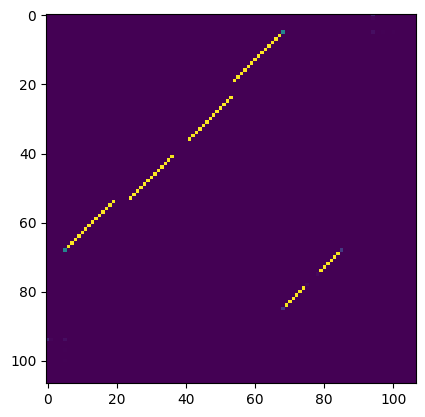

In [ ]:
# let's take a look at the predictions
import matplotlib.pyplot as plt
plt.imshow(test_preds[0][0])


### Convert bpp matrices to punp vectors.

In [ ]:

bpp_vector_list = []
for i in range(len(test_preds)):
    bpp_vector_list.append(1-np.sum((test_preds[i][0]), axis=0))




print(len(bpp_vector_list[0]))


107


In [ ]:
df = pd.read_json(json_file)

# Assume df is the DataFrame loaded from the initial JSON file
# p_unp_list is the list of vectors

# Truncate each vector in p_unp_list to a length of 79
truncated_vectors = [vec[:79] for vec in bpp_vector_list]

# Add the truncated vectors as a new column "p_unp_new" to the DataFrame
df['p_RibonanzaNet'] = truncated_vectors

# Save the DataFrame to a new JSON file
output_file = '/content/EternaBench_ChemMapping_Example_PunpVectors_Round1_with_RibonanzaNet.json'
df.to_json(output_file, orient='records', indent=2)

print(f"New JSON file saved as {output_file} with the added 'p_RibonanzaNet' column.")

New JSON file saved as /content/EternaBench_ChemMapping_Example_PunpVectors_Round1_with_RibonanzaNet.json with the added 'p_RibonanzaNet' column.


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# List to store Pearson correlation values
pearson_coefficients = []

# Function to compute and store Pearson correlation for a given row
def compute_and_store_pearson(row_index):
    # Extract the row based on index
    row = df.iloc[row_index]

    # Ensure that both vectors are the same length (79)
    reactivity_vector = row['reactivity'][:79]
    p_unp_new_vector = row['p_RibonanzaNet'][:79]

    try:
        # Calculate Pearson correlation
        correlation, _ = pearsonr(reactivity_vector, p_unp_new_vector)
        # Append the correlation value to the list
        pearson_coefficients.append(correlation)
    except ValueError as e:
        # Handle cases where Pearson correlation is undefined
        print(f'Row {row_index} skipped due to error: {e}')

# Compute Pearson correlation for each row
for i in range(len(df)):
    compute_and_store_pearson(i)

# Optionally, compute the average Pearson correlation
if pearson_coefficients:
    average_correlation = sum(pearson_coefficients) / len(pearson_coefficients)
    print(f'Average Pearson correlation: {average_correlation}')
else:
    print('No valid Pearson correlation values computed.')

# Optionally, save the Pearson coefficients to a file (e.g., a .json file)
import json
with open('/content/pearson_coefficients.csv', 'w') as f:
    json.dump(pearson_coefficients, f)

print('Pearson coefficients saved to pearson_coefficients.csv')


<ipython-input-24-a92e7dac69d6>:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(reactivity_vector, p_unp_new_vector)


Average Pearson correlation: nan
Pearson coefficients saved to pearson_coefficients.csv


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Function to compute and print Pearson correlation for a given row
def compute_and_print_pearson(row_index):
    # Extract the row based on index
    row = df.iloc[row_index]

    # Ensure that both vectors are the same length (79)
    reactivity_vector = row['reactivity'][:79]
    p_unp_new_vector = row['p_RibonanzaNet'][:79]

    # Calculate Pearson correlation
    correlation, _ = pearsonr(reactivity_vector, p_unp_new_vector)

    # Print the Pearson correlation for the current row
    print(f'Row {row_index}: Pearson correlation = {correlation}')

# Compute and print Pearson correlation for each row
for i in range(len(df)):
    compute_and_print_pearson(i)

Row 0: Pearson correlation = 0.7906771395990724
Row 1: Pearson correlation = 0.7026028584274489
Row 2: Pearson correlation = 0.7864430614861526
Row 3: Pearson correlation = 0.723809423132492
Row 4: Pearson correlation = 0.7656199509343532
Row 5: Pearson correlation = 0.7233494464163975
Row 6: Pearson correlation = 0.7617465198035305
Row 7: Pearson correlation = 0.6748665430268023
Row 8: Pearson correlation = 0.8248409194610906
Row 9: Pearson correlation = 0.7631708688968605
Row 10: Pearson correlation = 0.7111452736908882
Row 11: Pearson correlation = 0.7737516689669205
Row 12: Pearson correlation = 0.7973187950544774
Row 13: Pearson correlation = 0.7771284772263936
Row 14: Pearson correlation = 0.7791071060930909
Row 15: Pearson correlation = 0.7035468684354881
Row 16: Pearson correlation = 0.756918747827295
Row 17: Pearson correlation = 0.8409826854161699
Row 18: Pearson correlation = 0.8182282083537122
Row 19: Pearson correlation = 0.83827078485874
Row 20: Pearson correlation = 0.79

<ipython-input-20-93d78e724210>:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(reactivity_vector, p_unp_new_vector)


Row 399: Pearson correlation = 0.8117075448796286
Row 400: Pearson correlation = 0.7982256127500513
Row 401: Pearson correlation = 0.8680914448070903
Row 402: Pearson correlation = 0.67796742121999
Row 403: Pearson correlation = 0.8152532639781386
Row 404: Pearson correlation = 0.8392859552205657
Row 405: Pearson correlation = 0.7807834614617396
Row 406: Pearson correlation = 0.7521724549524077
Row 407: Pearson correlation = 0.7275917089724186
Row 408: Pearson correlation = 0.4039381292319437
Row 409: Pearson correlation = 0.8070063639130184
Row 410: Pearson correlation = 0.8208044691811153
Row 411: Pearson correlation = 0.6796207691671606
Row 412: Pearson correlation = 0.7344632483507246
Row 413: Pearson correlation = 0.686190098129081
Row 414: Pearson correlation = 0.7606456392417574
Row 415: Pearson correlation = 0.4344058968326863
Row 416: Pearson correlation = 0.7044865449972051
Row 417: Pearson correlation = 0.7139908283095963
Row 418: Pearson correlation = 0.7868754281360609
Row

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# List to store Pearson correlation values
correlations = []

# Function to compute Pearson correlation for a given row and store it
def compute_pearson(row_index):
    # Extract the row based on index
    row = df.iloc[row_index]

    # Ensure that both vectors are the same length (79)
    reactivity_vector = row['reactivity'][:79]
    p_RibonanzaNet = row['p_RibonanzaNet'][:79]

    # Calculate Pearson correlation
    correlation, _ = pearsonr(reactivity_vector, p_RibonanzaNet)

    # Append the correlation value to the list
    correlations.append(correlation)

# Compute Pearson correlation for each row
for i in range(len(df)):
    compute_pearson(i)

# Calculate and print the average Pearson correlation
average_correlation = sum(correlations) / len(correlations)
print(f'Average Pearson correlation: {average_correlation}')


<ipython-input-19-fe42f87cc897>:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(reactivity_vector, p_RibonanzaNet)


Average Pearson correlation: nan
